In [1]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
import gc
import warnings
from tqdm import tqdm
from sklearn.metrics import f1_score
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split

warnings.filterwarnings('ignore')

pd.set_option('display.unicode.ambiguous_as_wide', True)
pd.set_option('display.unicode.east_asian_width', True)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option("display.max_colwidth", 100)
pd.set_option('display.width', 1000)

In [2]:
# 节省内存读文件
def reduce_mem_usage(df):
    """
    iterate through all the columns of a dataframe and modify the data type to reduce memory usage.
    @param df:
    @return:
    """
    start_mem = df.memory_usage().sum()
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('str')

    end_mem = df.memory_usage().sum()
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    return df

In [3]:
train_user = reduce_mem_usage(pd.read_csv('../input/train/train_user.csv'))
test_user = reduce_mem_usage(pd.read_csv('../input/test/test_user.csv'))

Memory usage of dataframe is 635152.00 MB
Memory usage after optimization is: 256580.00 MB
Decreased by 59.6%
Memory usage of dataframe is 81928.00 MB
Memory usage after optimization is: 55343.00 MB
Decreased by 32.4%


In [4]:
# 训练集只取最后一个月的数据
train_user['arpu_202004'] = train_user['arpu_202003']
train_user.drop(['arpu_201908', 'arpu_201909', 'arpu_201910', 'arpu_201911',
                 'arpu_201912', 'arpu_202001', 'arpu_202002', 'arpu_202003'],
                axis=1,
                inplace=True)

In [5]:
df_user = pd.concat([train_user, test_user])

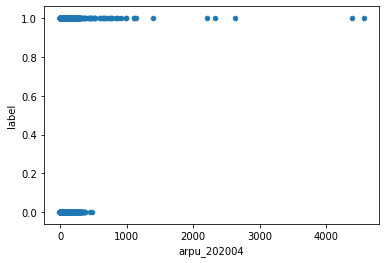

In [6]:
# label与话费额
train_user.plot.scatter(x='arpu_202004', y='label')

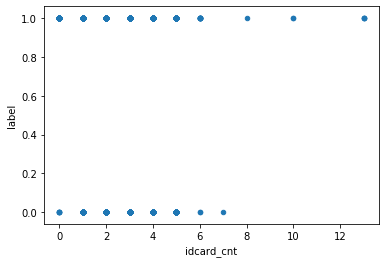

In [7]:
# label与idcard_cnt
train_user.plot.scatter(x='idcard_cnt', y='label')

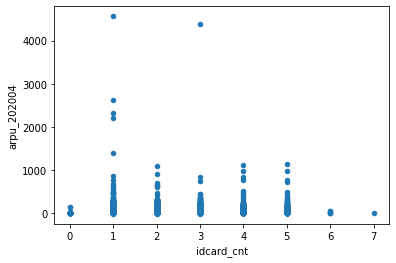

In [8]:
train_user.plot.scatter(x='idcard_cnt', y='arpu_202004')

In [9]:
# 将city_name和county_name拼接起来
df_user['city_name_county_name'] = df_user['city_name'].astype(str) + '_' + df_user['county_name'].astype(str)

In [10]:
# 电话的数量*月消费额
df_user['idcard_cnt*arpu_202004'] = df_user['idcard_cnt'] * df_user['arpu_202004']

In [11]:
cat_feat = ['city_name', 'county_name', 'city_name_county_name']

In [12]:
num_feat = ['idcard_cnt', 'arpu_202004', 'idcard_cnt*arpu_202004']

In [13]:
def cross_cat_num(df, cat_col, num_col):
    for f1 in tqdm(cat_col):
        g = df.groupby(f1, as_index=False)
        for f2 in tqdm(num_col):
            df_new = g[f2].agg({
                '{}_{}_max'.format(f1, f2): 'max',
                '{}_{}_min'.format(f1, f2): 'min',
                '{}_{}_median'.format(f1, f2): 'median',
                '{}_{}_mean'.format(f1, f2): 'mean',
                '{}_{}_skew'.format(f1, f2): 'skew',
                '{}_{}_nunique'.format(f1, f2): 'nunique'
            })
            df = df.merge(df_new, on=f1, how='left')
            del df_new
            gc.collect()
    return df

In [14]:
df_user = cross_cat_num(df_user, cat_feat, num_feat)

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.97it/s]


In [15]:
# LABEL ENCODE
def label_encode(df, cols, verbose=True):
    for col in cols:
        df[col], _ = df[col].factorize(sort=True)
        if df[col].max() > 32000: 
            df[col] = df[col].astype('int32')
        else:
            df[col] = df[col].astype('int16')
        if verbose:
            print(col)

In [16]:
label_encode(df_user, cat_feat)

city_name
county_name
city_name_county_name


In [17]:
# 将类别特征处理为category
for f in cat_feat:
    df_user[f] = df_user[f].astype('category')

In [18]:
def count_encode(df, cols=[]):
    for col in cols:
        print(col)
        vc = df[col].value_counts(dropna=True, normalize=True)
        df[col + '_count'] = df[col].map(vc).astype('float32')

In [19]:
count_encode(df_user, cat_feat + ['idcard_cnt'])

city_name
county_name
city_name_county_name
idcard_cnt


In [20]:
df_user_train = df_user[df_user.label.notna()]
df_user_test = df_user[df_user.label.isna()]

df_user_train.shape, df_user_test.shape

((6106, 66), (2045, 66))

In [21]:
X_train, X_valid, y_train, y_valid = train_test_split(df_user_train.drop('label', axis=1), df_user_train['label'],
                                                      test_size=0.2,
                                                      random_state=2020)

In [22]:
train_cols = [i for i in X_train if i not in ['phone_no_m', 'label']]

In [23]:
params = {'objective': 'binary',
          'boosting': 'gbdt',
          'metric': 'auc',
          'learning_rate': 0.1,
          'num_leaves': 31,
          'lambda_l1': 0,
          'lambda_l2': 1,
          'min_data_in_leaf': 20,
          'is_unbalance': True,
          'max_depth': -1,
          'seed': 2020}

In [24]:
useful_cols = []
useless_cols = []

for i in train_cols:
    print(i)
    lgb_train = lgb.Dataset(X_train[[i]].values, y_train) 
    lgb_eval= lgb.Dataset(X_valid[[i]].values, y_valid, reference=lgb_train)
    lgb_test = lgb.train(params,
                         lgb_train,
                         num_boost_round=1000,
                         valid_sets=[lgb_eval, lgb_train],
                         early_stopping_rounds=50,
                         verbose_eval=20)
    
    print('*' * 5)
    print(lgb_test.best_score['valid_0']['auc'])
    if lgb_test.best_score['valid_0']['auc'] > 0.50:
        useful_cols.append(i)
    else:
        useless_cols.append(i)
    print('*' * 20)
    print('\n')

city_name
Training until validation scores don't improve for 50 rounds
[20]	training's auc: 0.684155	valid_0's auc: 0.671655
[40]	training's auc: 0.684158	valid_0's auc: 0.671655
Early stopping, best iteration is:
[2]	training's auc: 0.684155	valid_0's auc: 0.671655
*****
0.6716545295833931
********************


county_name
Training until validation scores don't improve for 50 rounds
[20]	training's auc: 0.766692	valid_0's auc: 0.72058
[40]	training's auc: 0.771795	valid_0's auc: 0.728874
[60]	training's auc: 0.773536	valid_0's auc: 0.730451
[80]	training's auc: 0.774428	valid_0's auc: 0.731249
[100]	training's auc: 0.775065	valid_0's auc: 0.732053
[120]	training's auc: 0.775649	valid_0's auc: 0.732648
[140]	training's auc: 0.776192	valid_0's auc: 0.732062
[160]	training's auc: 0.7765	valid_0's auc: 0.731618
Early stopping, best iteration is:
[121]	training's auc: 0.775662	valid_0's auc: 0.732708
*****
0.7327076457645765
********************


idcard_cnt
Training until validation scor

[6]	training's auc: 0.684058	valid_0's auc: 0.671655
*****
0.6716545295833931
********************


county_name_idcard_cnt_max
Training until validation scores don't improve for 50 rounds
[20]	training's auc: 0.633927	valid_0's auc: 0.644783
[40]	training's auc: 0.633927	valid_0's auc: 0.644783
[60]	training's auc: 0.633927	valid_0's auc: 0.644783
Early stopping, best iteration is:
[20]	training's auc: 0.633927	valid_0's auc: 0.644783
*****
0.6447825489070647
********************


county_name_idcard_cnt_min
Training until validation scores don't improve for 50 rounds
[20]	training's auc: 0.607294	valid_0's auc: 0.605336
[40]	training's auc: 0.607294	valid_0's auc: 0.605336
Early stopping, best iteration is:
[1]	training's auc: 0.607294	valid_0's auc: 0.605336
*****
0.6053355335533553
********************


county_name_idcard_cnt_median
Training until validation scores don't improve for 50 rounds
[20]	training's auc: 0.605693	valid_0's auc: 0.605673
[40]	training's auc: 0.606365	valid

[80]	training's auc: 0.764292	valid_0's auc: 0.716778
[100]	training's auc: 0.765556	valid_0's auc: 0.717919
[120]	training's auc: 0.766804	valid_0's auc: 0.719796
[140]	training's auc: 0.767513	valid_0's auc: 0.719742
[160]	training's auc: 0.76799	valid_0's auc: 0.72142
[180]	training's auc: 0.768489	valid_0's auc: 0.72049
[200]	training's auc: 0.768943	valid_0's auc: 0.719967
Early stopping, best iteration is:
[160]	training's auc: 0.76799	valid_0's auc: 0.72142
*****
0.7214195604343043
********************


county_name_idcard_cnt*arpu_202004_mean
Training until validation scores don't improve for 50 rounds
[20]	training's auc: 0.7668	valid_0's auc: 0.720179
[40]	training's auc: 0.771517	valid_0's auc: 0.722201
[60]	training's auc: 0.773697	valid_0's auc: 0.722721
[80]	training's auc: 0.774744	valid_0's auc: 0.723576
[100]	training's auc: 0.775706	valid_0's auc: 0.724307
[120]	training's auc: 0.776731	valid_0's auc: 0.726475
[140]	training's auc: 0.777466	valid_0's auc: 0.726777
[16

[60]	training's auc: 0.773364	valid_0's auc: 0.725824
[80]	training's auc: 0.774457	valid_0's auc: 0.726117
[100]	training's auc: 0.774931	valid_0's auc: 0.726662
[120]	training's auc: 0.775474	valid_0's auc: 0.727238
[140]	training's auc: 0.775991	valid_0's auc: 0.728457
[160]	training's auc: 0.776298	valid_0's auc: 0.728507
[180]	training's auc: 0.776497	valid_0's auc: 0.728917
[200]	training's auc: 0.776638	valid_0's auc: 0.729416
[220]	training's auc: 0.776803	valid_0's auc: 0.729527
[240]	training's auc: 0.776916	valid_0's auc: 0.729623
[260]	training's auc: 0.777035	valid_0's auc: 0.729766
[280]	training's auc: 0.777132	valid_0's auc: 0.730077
[300]	training's auc: 0.777208	valid_0's auc: 0.729856
Early stopping, best iteration is:
[266]	training's auc: 0.777076	valid_0's auc: 0.730095
*****
0.7300948844884488
********************


city_name_county_name_idcard_cnt*arpu_202004_min
Training until validation scores don't improve for 50 rounds
[20]	training's auc: 0.590763	valid_0's

In [25]:
print(useful_cols)

['city_name', 'county_name', 'idcard_cnt', 'arpu_202004', 'city_name_county_name', 'idcard_cnt*arpu_202004', 'city_name_idcard_cnt_max', 'city_name_idcard_cnt_min', 'city_name_idcard_cnt_median', 'city_name_idcard_cnt_mean', 'city_name_idcard_cnt_skew', 'city_name_idcard_cnt_nunique', 'city_name_arpu_202004_max', 'city_name_arpu_202004_min', 'city_name_arpu_202004_median', 'city_name_arpu_202004_mean', 'city_name_arpu_202004_nunique', 'city_name_idcard_cnt*arpu_202004_max', 'city_name_idcard_cnt*arpu_202004_min', 'city_name_idcard_cnt*arpu_202004_median', 'city_name_idcard_cnt*arpu_202004_mean', 'city_name_idcard_cnt*arpu_202004_nunique', 'county_name_idcard_cnt_max', 'county_name_idcard_cnt_min', 'county_name_idcard_cnt_median', 'county_name_idcard_cnt_mean', 'county_name_idcard_cnt_skew', 'county_name_idcard_cnt_nunique', 'county_name_arpu_202004_max', 'county_name_arpu_202004_min', 'county_name_arpu_202004_median', 'county_name_arpu_202004_mean', 'county_name_arpu_202004_skew', 'cou

In [26]:
print(useless_cols)

['city_name_arpu_202004_skew', 'city_name_idcard_cnt*arpu_202004_skew']


In [27]:
lgb_data = lgb.Dataset(df_user_train[useful_cols].values, df_user_train['label'])

cv_results = lgb.cv(params,
                    lgb_data,
                    num_boost_round=1000,
                    early_stopping_rounds=200,
                    eval_train_metric=True,
                    stratified=True,
                    shuffle=True,
                    nfold=3)
cv_df = pd.DataFrame(cv_results)
cv_df

,train auc-mean,train auc-stdv,valid auc-mean,valid auc-stdv
0,0.889027,0.006442,0.851899,0.012195
1,0.899969,0.005260,0.858801,0.008908
2,0.905491,0.004933,0.861434,0.011176
3,0.908969,0.005242,0.864224,0.009267
4,0.912835,0.003228,0.865619,0.009369
5,0.914682,0.003509,0.866564,0.009278
6,0.916602,0.002997,0.867773,0.009720
7,0.918534,0.003408,0.867995,0.009088
8,0.920482,0.002966,0.868118,0.008817
9,0.922966,0.003012,0.869412,0.008760


In [28]:
len(cv_df)

43

In [29]:
lgb_train = lgb.train(params,
                      lgb_data,
                      num_boost_round=len(cv_df),
                      valid_sets=lgb_data,
                      verbose_eval=100)

In [31]:
df_user_test['label'] = np.where(lgb_train.predict(df_user_test[useful_cols]) > 0.5, 1, 0)
df_user_test[['phone_no_m', 'label']].to_csv('../sub/sub_{}.csv'.format(time.strftime('%Y%m%d')), index=False)